# Assignment 10A - Hasanat Hasan

### In this problem we consider a 1D metal rod of length L, where the temperature distribution T(t,x) at t = 0 is given by a finite sum of sine modes
$$
T(0,x)  = \sum_{n=1}^{N}c_n \sin(\frac{n\pi x}{L})
$$
### The temperature profile evolves according to the equations:
$$
\frac{\partial T(t,x)}{\partial t} = \alpha \frac{\partial^2 T(t,x)}{\partial t^2} 
$$

### where $\alpha$ is the thermal diffusivity. The boundary conditions are assumed to be the following:
$$
T(t,0) = 0, T(t,L) = 0
$$
### The corresponding exact solution for the temperature at any time t is given by:
$$
T(t,x) = \sum_{n=1}^{N}c_n e^{-\alpha \left( \frac{n\pi}{L} \right)^2 t} \sin(\frac{n\pi x}{L})
$$

### Since the Fourier modes with higher n are suppressed exponentially, we expect that the temperature profile is dominated by only a few Fourier components after enough time (regardless of the temperature profile of the rod at t = 0). In this assignment, you will analyze the time evolution of the system and apply Gaussian Process Regression (GPR) to reconstruct the temperature profile at different times, leveraging this general feature of the heat equation.

## Problem 1 (200 points): Gaussian Process Regression with Physics-Informed Prior
### (a) Compute the prior covariance matrix Ass′, using the physics-informed choice:
$$
A_{s,s'} = e^{\alpha \left( \frac{n\pi}{L} \right)^2 t} \delta_{s,s'}
$$
### The covariance matrix captures the  the cause-response (foward) relation. The temp at t+1 is related by the temp t by the exponential decay
### Compute $A^{−1}_{s,s′}$ and use it to construct the kernel function
$$
K(x,x') = \sum_{s=1}^{N} A^{-1}_{s,s'} \sin(\frac{s\pi x}{L})\sin(\frac{s\pi x'}{L})
$$
### Compute and plot $K(x,x′)$ for times $t = 0,0.25,0.5,0.75,1,2$.

# Utilities

In [1]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng(42)

def prior_covar(time: float, N_modes: float, alpha: float, length: float):
    ''' 
    Calculates the covariance matrix:
        A_{ss'} = exp(a*t*(n pi/L)^2) delta_{s,s'}
    '''
    t: float = time
    n: float = N_modes
    a: float = alpha
    L: float = length

    return np.diag([np.exp(a*(((i*np.pi)/L))**2)**t for i in range(1,n+1)])

def kernel_function(length: float,
                     N_modes: int,
                     x: float, 
                     x_prime: float,
                     A_inv: np.ndarray)-> float:
    ''' 
    Computes kernel function at time t:
        K(x,x') = \sum A^{-1}_{ss} sin(s pi x/L) sin(s pi x'/L)
    '''
    # Calculate arguments for sine functions
    L: float                = length
    modes: np.ndarray       = np.arange(1, N_modes + 1)  # Modes from 1 to N_modes
    x_args: np.ndarray      = (modes * np.pi * x) / L
    xprime_args: np.ndarray = (modes * np.pi * x_prime) / L

    # Compute sine values
    sin_x: np.ndarray       = np.sin(x_args)
    sin_xprime: np.ndarray  = np.sin(xprime_args)

    # Compute the kernel using vectorized operations
    kernel: float = np.sum(A_inv.diagonal() * sin_x * sin_xprime)

    return kernel

def kernel_matrix(length: float,
                     N_modes: int,
                     X_array: np.ndarray, 
                     A_inv: np.ndarray)->np.ndarray:
    ''' 
    Computes kernel matrix at time t:
        [K]_{x,x'} = \sum A^{-1}_{ss} sin(s pi x/L) sin(s pi x'/L)
    '''
    # Calculate arguments for sine functions
    L: float = length
    modes: np.ndarray       = np.arange(1, N_modes + 1)  # Modes from 1 to N_modes
    x_mesh, xprime_mesh     = np.meshgrid(X_array, X_array, indexing='ij')  

    # Compute sine values
    sine_x: np.ndarray      = np.sin((modes[:, None, None] * np.pi * x_mesh) / L) 
    sine_xprime: np.ndarray = np.sin((modes[:, None, None] * np.pi * xprime_mesh) / L) 
    kernel: np.ndarray      = np.sum(A_inv.diagonal()[:, None, None] * sine_x * sine_xprime, axis=0)  
    return kernel

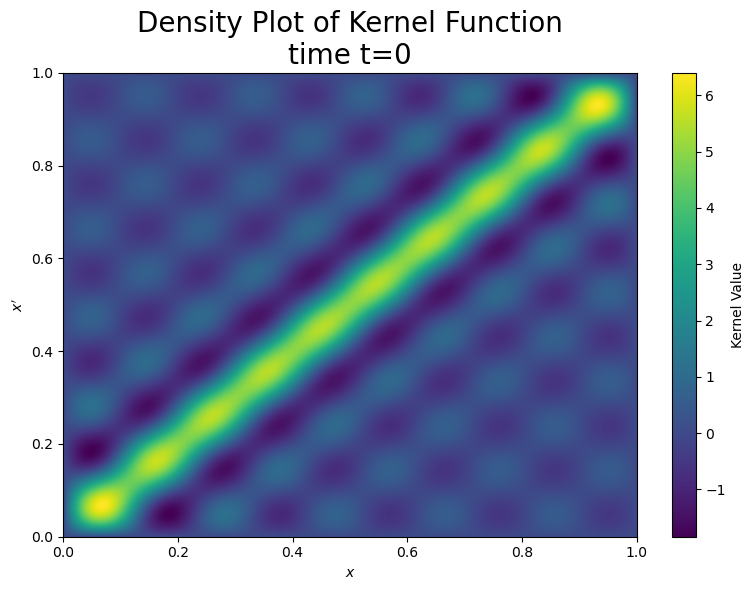

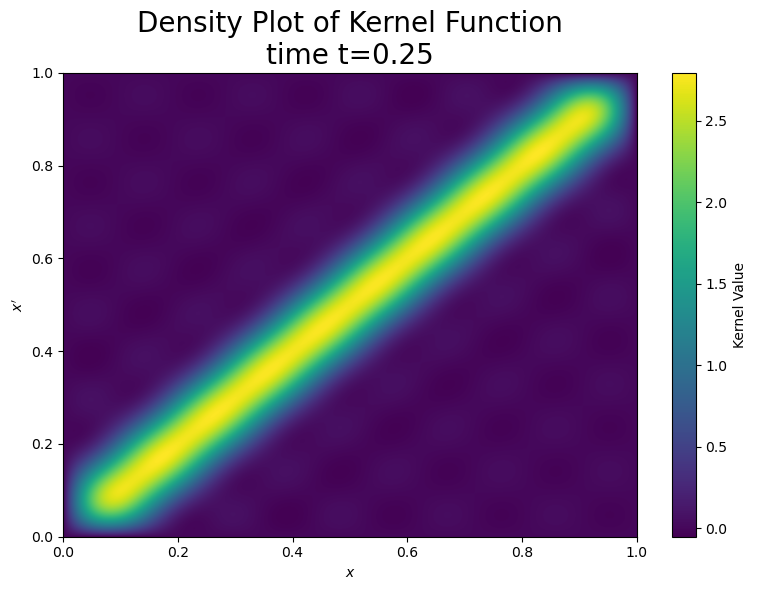

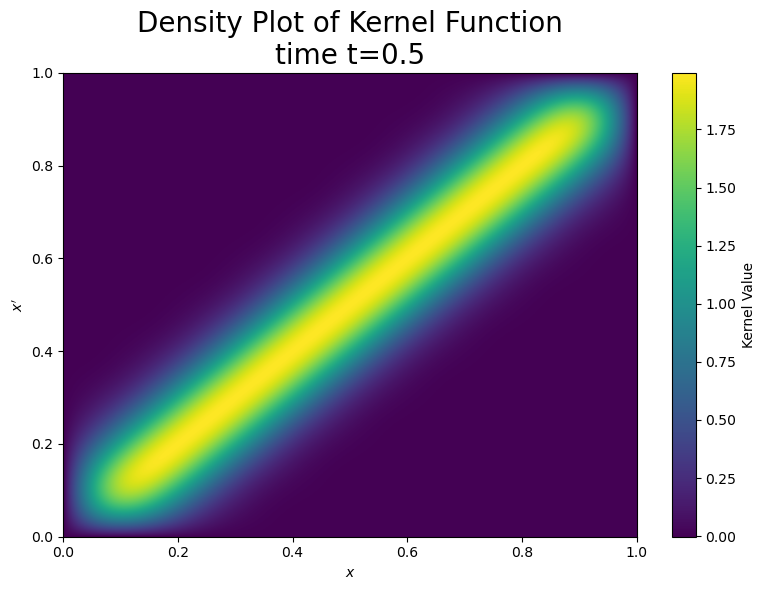

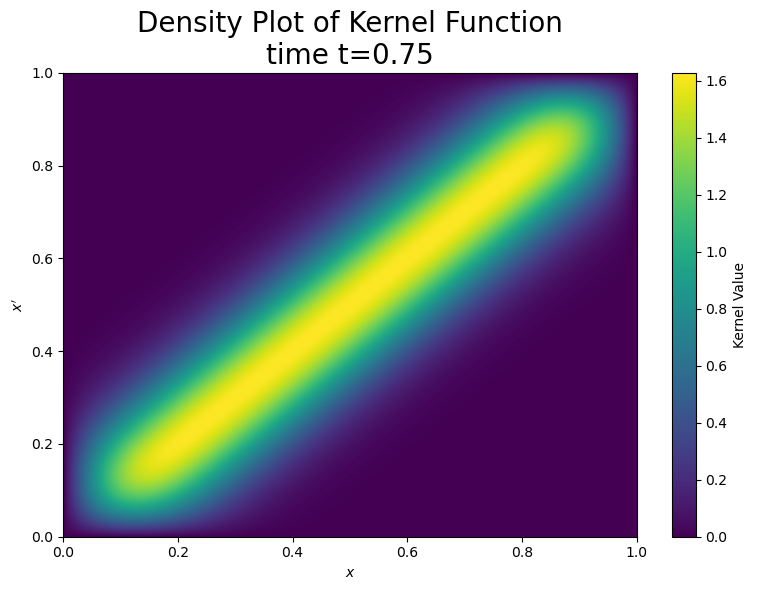

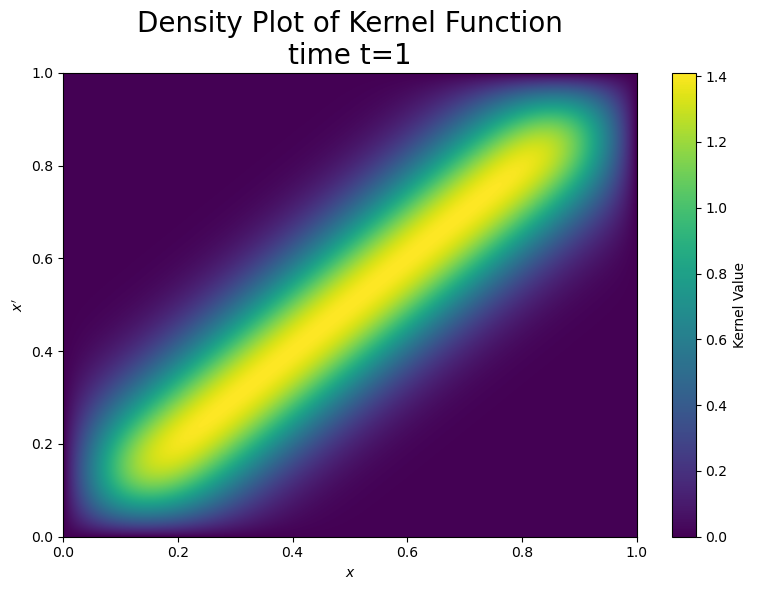

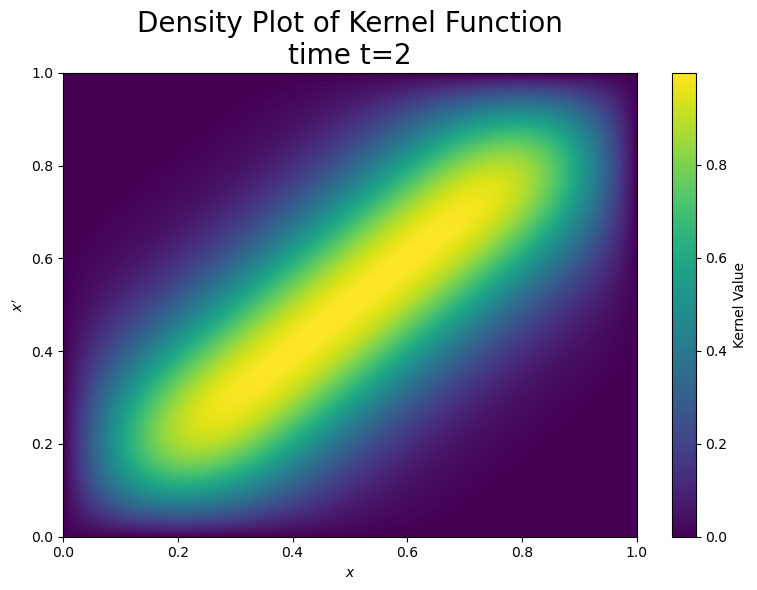

In [ ]:
import numpy.linalg as linalg
import matplotlib.pyplot as plt
import numpy as np

# Parameters
# t = 1           # time 
L = 1.0         # Length of the rod
alpha = 0.01    # Thermal diffusivity
N_modes = 10    # Number of sine modes in the initial condition
divisions = 1000
x_step = L / divisions
time_list = [0,0.25,0.5,0.75,1,2]
X_array = np.arange(0, L + x_step, x_step)

for time in time_list: 

    # Compute the kernel matrix using broadcasting
    A = prior_covar(time, N_modes, alpha, L)
    A_inv = linalg.inv(A)
    kernel_vals = kernel_matrix(L, N_modes,X_array, A_inv)

    # Create the density plot
    plt.figure(figsize=(8, 6))
    plt.imshow(kernel_vals, extent=(0, L, 0, L), origin='lower', cmap='viridis', aspect='auto')
    plt.colorbar(label="Kernel Value")
    plt.title(f"Density Plot of Kernel Function\ntime t={time}",size=20)
    plt.xlabel("$x$")
    plt.ylabel("$x'$")
    plt.tight_layout()
    plt.show()


### (b) Compute the covariance matrix  $\bar{K}_{\alpha, \beta} $ for the training data, incorporating the measurement uncertainty $\sigma$:
$$
\bar{K}_{\alpha, \beta} = K(x_{\alpha}, x_{\beta}) + \sigma^2\delta_{\alpha, \beta}
$$
### The measurements correspond to temperature values extracted from the provided function at:
$$
x_{\alpha} = [L/6, L/3, L/2, 2*L/3, 5*L/6 ]
$$
### Denoting these measurements as $T_{\alpha} = T(t,x_{\alpha})$, with measurement uncertainty $\sigma = 0.01$, compute the mean prediction"
$$
\langle T(x) \rangle = \sum_{\alpha, \beta} K(x,x_{\alpha}) \bar{K}_{\alpha, \beta}^{-1} T_{\beta} 
$$
### and the standard deviation:
$$
\sigma^2_{\text{post}}(x)= K(x,x) - \sum_{\alpha, \beta} K(x,x_{\alpha}) \bar{K}_{\alpha, \beta}^{-1} K(x_{\beta},x)  
$$

## Utilities

In [9]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng(2)
# Function to compute the initial temperature profile
def initial_temperature(x, L, c_n):
    return sum(c_n[n] * np.sin((n+1) * np.pi * x / L) for n in range(len(c_n)))

def temp_distr(a: float,x: np.ndarray,t: float, L: float, c_n: np.ndarray):
    return sum(c_n[n] * np.exp(-a*t*((((n+1)*np.pi)/L))**2) *np.sin((n+1) * np.pi * x / L) for n in range(len(c_n)))

def measure_T(a: float,
              t: float,
              x_list: list,
              length: float,
              coeffs: np.ndarray):
    ''' 
    Measures temperatures at specified points in x_list
    '''
    L: float = length
    c_n: np.ndarray = coeffs
    Temperature_list = []
    for x in x_list:
        T = temp_distr(a,x,t,L,c_n)
        Temperature_list.append(float(T))
    return Temperature_list

def prior_covar(time: float, N_modes: float, alpha: float, length: float):
    ''' 
    Calculates the covariance matrix:
        A_{ss'} = exp(a*t*(n pi/L)^2) delta_{s,s'}
    '''
    t: float = time
    n: float = N_modes
    a: float = alpha
    L: float = length

    return np.diag([np.exp(a*(((i*np.pi)/L))**2)**t for i in range(1,n+1)])

def kernel_function(length: float,
                    N_modes: int,
                    x: float, 
                    x_prime: float,
                    A_inv: np.ndarray)-> float:
    ''' 
    Computes kernel function at time t:
        K(x,x') = \sum A^{-1}_{ss} sin(s pi x/L) sin(s pi x'/L)
    '''
    # Calculate arguments for sine functions
    L: float                = length
    modes: np.ndarray       = np.arange(1, N_modes + 1)  # Modes from 1 to N_modes
    x_args: np.ndarray      = (modes * np.pi * x) / L
    xprime_args: np.ndarray = (modes * np.pi * x_prime) / L

    # Compute sine values
    sin_x: np.ndarray       = np.sin(x_args)
    sin_xprime: np.ndarray  = np.sin(xprime_args)

    # Compute the kernel using vectorized operations
    kernel: float = np.sum(A_inv.diagonal() * sin_x * sin_xprime)

    return kernel

def kernel_matrix(length: float,
                     N_modes: int,
                     X_array: np.ndarray, 
                     A_inv: np.ndarray)->np.ndarray:
    ''' 
    Computes kernel matrix at time t:
        [K]_{x,x'} = \sum A^{-1}_{ss} sin(s pi x/L) sin(s pi x'/L)
    '''
    # Calculate arguments for sine functions
    L: float = length
    modes: np.ndarray       = np.arange(1, N_modes + 1)  # Modes from 1 to N_modes
    x_mesh, xprime_mesh     = np.meshgrid(X_array, X_array, indexing='ij')  

    # Compute sine values
    sine_x: np.ndarray      = np.sin((modes[:, None, None] * np.pi * x_mesh) / L) 
    sine_xprime: np.ndarray = np.sin((modes[:, None, None] * np.pi * xprime_mesh) / L) 
    kernel: np.ndarray      = np.sum(A_inv.diagonal()[:, None, None] * sine_x * sine_xprime, axis=0)  
    return kernel

def mean_prediction(x: float,
                    length: float,
                    N_modes: int,
                    A_inv: np.ndarray,
                    kernel_func: callable,
                    covar_matrix: np.ndarray,
                    x_list: np.ndarray,
                    measured_temp: np.ndarray):
    ''' 
    calculates the mean predictions:
        <T(x)> = \sum_{ab} K(x,x_a) Kbar^-1_{ab} T_b
    '''
    L: float = length
    N: int = N_modes
    temp: np.ndarray = measured_temp
    mean: float = 0.0
    kbar_inv = linalg.inv(covar_matrix)
    for i in range(len(x_list)):
        for j in range(len(x_list)):
            mean += kernel_func(L, N, x,x_list[i], A_inv) * kbar_inv[i,j] * temp[j]
    return mean

def variance(length: float,
            N_modes: int,
            x: float, 
            x_list: list,
            A_inv: np.ndarray,
            Kbar: np.ndarray,
            kernel_function: callable):
    ''' 
    calculates the variance:
        \sigma^2(x) = K(x,x) - \sum_{ab}K(x,x_a)Kbar^-1_{ab}K(x_b,x_a) 
    '''
    N: int = N_modes
    L: float = length
    samples: int = len(x_list) 
    Kbar_inv = linalg.inv(Kbar)
    var = kernel_function(L,N,x,x, A_inv)
    for a in range(samples):
        Kx_xa = kernel_function(L,N,x,x_list[a], A_inv)
        for b in range(samples):
            Kxb_x = kernel_function(L,N, x_list[b], x, A_inv) 
            var -= Kx_xa * Kbar_inv[a,b] * Kxb_x
    return var

def stdev(variance: float):
    return np.sqrt(variance)


## Example Implementation:

In [ ]:
import numpy.linalg as linalg
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng(42)

# Generate random Fourier coefficients
time = 0.5           # time 
L = 1.0           # Length of the rod
alpha = 0.01      # Thermal diffusivity
N_modes = 5      # Number of sine modes in the initial condition
sigma = 0.01
divisions = 1000
x_step = L / divisions

x = 0.2 # evaluating at this example position:

A= prior_covar(time, N_modes, alpha, L)
A_inv= linalg.inv(A)
measurement_points= [L/6, L/3, L/2, 2*L/3, 5*L/6 ]
Kbar= kernel_matrix(L, N_modes, measurement_points,A_inv ) + (sigma**2) * np.eye(len(measurement_points))

c_n= rng.uniform(-1, 1, N_modes)
Temperature_list = measure_T(alpha, time, measurement_points,L, c_n )
kernel= lambda l, n, x, xp, A: kernel_function(l, n, x, xp, A)

ave_T = mean_prediction(x,L,N_modes,A_inv,kernel,Kbar,measurement_points,Temperature_list)

var = variance(L,N_modes,x,measurement_points,A_inv,Kbar,kernel_function)

print("Kbar=\n",Kbar)
print(f"at x={x}, T ={ave_T}")
print(f"variance for x = {x}, var = {var}")


Kbar=
 [[ 1.9084284   0.56118514 -0.01984926  0.01094317 -0.00403578]
 [ 0.56118514  1.88857915  0.57212832 -0.02388504  0.01094317]
 [-0.01984926  0.57212832  1.88454337  0.57212832 -0.01984926]
 [ 0.01094317 -0.02388504  0.57212832  1.88857915  0.56118514]
 [-0.00403578  0.01094317 -0.01984926  0.56118514  1.9084284 ]]
at x=0.2, T =0.9200682728115838
variance for x = 0.2, var = 8.332929349736434e-05


### (c) Perform the GPR reconstruction for the same times as the kernel calculations: t = 0, 0.25, 0.5, 0.75, 1, 2. Plot the predicted mean temperature profile ⟨T(x)⟩ for each case along with the standard deviation confidence interval (error bars). Compare the reconstructed function to thetrue solution of the heat equation at the corresponding time.

-0.7308895716797494


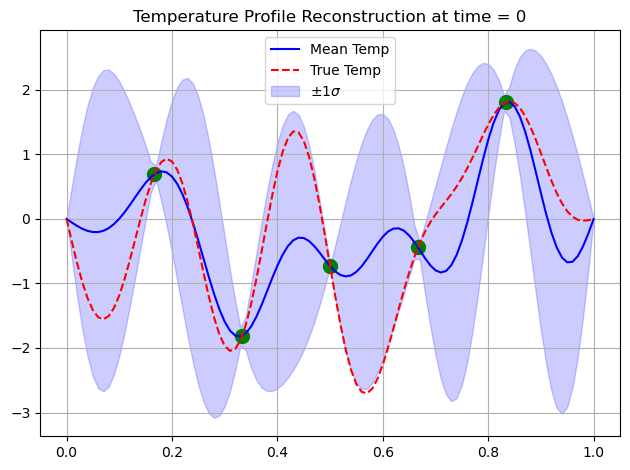

-0.7351015212959557


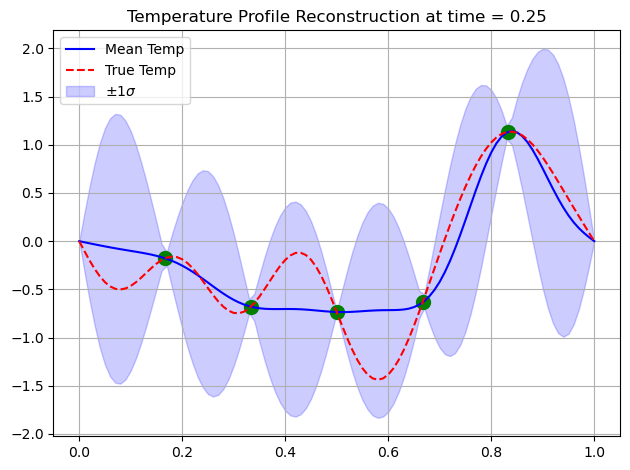

-0.7512478629901724


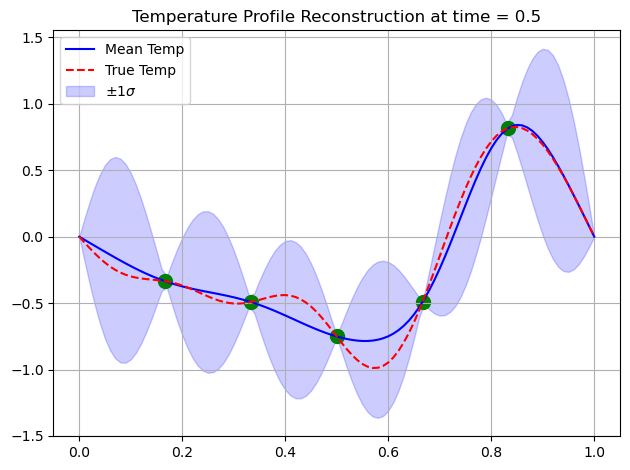

-0.7186261172727403


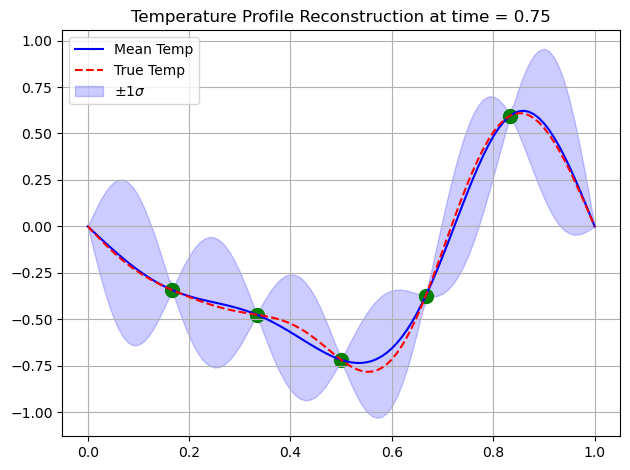

-0.6687119091720034


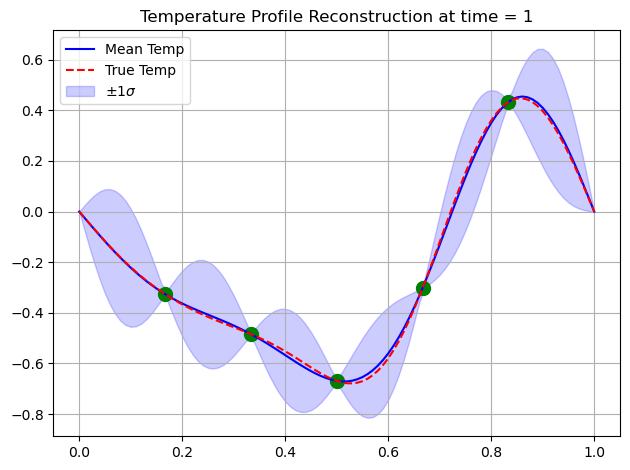

-0.49624059530043174


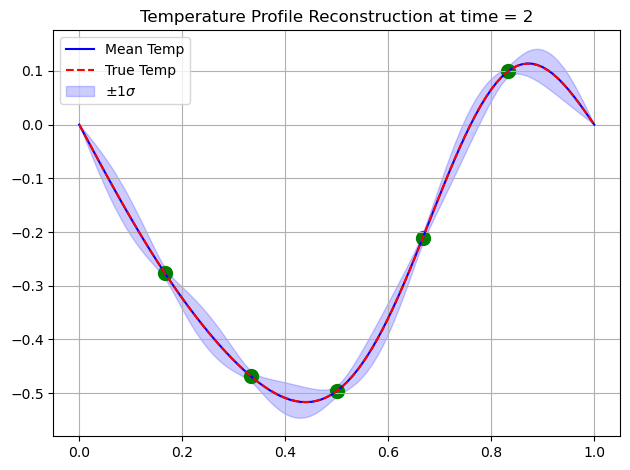

In [12]:
import numpy.linalg as linalg
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng(2)

# constant:
L = 1.0           # Length of the rod
alpha = 0.01      # Thermal diffusivity
N_modes = 10      # Number of sine modes in the initial condition
sigma = 0.01
divisions = 100

x_step = L / divisions
X_array = np.arange(0, L + x_step, x_step)
time_list = [0,0.25,0.5,0.75,1,2]
c_n = rng.uniform(-1, 1, N_modes)
measurement_points = [L/6, L/3, L/2, 2*L/3, 5*L/6 ]

for time in time_list:
    predict_list = np.zeros((len(X_array)))
    stdev_list = np.zeros((len(X_array)))
    A                = prior_covar(time, N_modes, alpha, L)
    A_inv            = linalg.inv(A)
    Kbar             = kernel_matrix(L, N_modes, measurement_points,A_inv ) + (sigma**2) * np.eye(len(measurement_points))
    Temperature_list = measure_T(alpha, time, measurement_points,L, c_n )
    print(Temperature_list[2])
    kernel           = lambda l, n, x, xp, A: kernel_function(l, n, x, xp, A)

    for idx,x in enumerate(X_array):
        ave_T = mean_prediction(x,L,N_modes,A_inv,kernel,Kbar,measurement_points,Temperature_list)
        predict_list[idx] = ave_T 
        var = variance(L,N_modes,x,measurement_points,A_inv,Kbar,kernel_function)
        stdev_list[idx]=np.sqrt(var)

    true_temp = temp_distr(alpha, X_array,time,L, c_n)
    plt.title(f"Temperature Profile Reconstruction at time = {time}")
    # plt.ylim(-3.5,3.5)
    plt.plot(X_array, predict_list, color='b', label ='Mean Temp')
    plt.plot(X_array,true_temp,color='r',linestyle='--',   label='True Temp')
    plt.fill_between(
        X_array,
        predict_list + stdev_list,
        predict_list - stdev_list,
        color='blue',
        alpha=0.2,
        label=r"$\pm 1\sigma$"
    )
    plt.scatter(measurement_points, Temperature_list, color='g', s=100)  # Adjust `s` for marker size
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



### (d) In the Jupyter Notebook, provide a brief explanation in markdown discussing the role of the prior covariance matrix Ass′in the Gaussian Process Regression model. Explain how the structure of $A_{ss′}$ encodes the expected physical behavior of the system and why this choice is justified based on the heat equation. Additionally, comment on the agreement between the reconstructed function and the actual temperature profile as a function of time.

- ### The prior covariance matrix imbues the knowledge that the solutions to the heat equation must contain an exponential factor that scales with the frequency of the sin wave, and that the sine waves create an orthogonal basis for functions. This orthogonality is reflected in A, as A is a diagonal matrix whose diagonal elements represent the magntidude of the basis functions. The Exponential factor in A is positive, and this is because the kernel function utilizes the inverse of A, which guarantees a decaying exponential factor, and thus reflects the thermalization of the system.
- ### At time = 0, the disagreement is at the highest because the exponential factor is equal to 1, thus it does not suppress any frequencies and allows for the maximum amount of possible functions that could satisfy the temperature measurements. As the system thermalizes, high frequencies get exponentially suppressed with time, which exponentially decreases the posible functions that fit our measurements and conditions.   

## Animations:

In [ ]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy.linalg as linalg
import numpy as np
rng = np.random.default_rng(27)

L = 1
x_divisions = 100
x_step = L / x_divisions
X_array = np.arange(0, L + x_step, x_step)

t_divisions = 100
t_step = 2/t_divisions
t_array = np.arange(0,2+t_step, t_step)

# constant:
L = 1.0           # Length of the rod
alpha = 0.01      # Thermal diffusivity
N_modes = 500      # Number of sine modes in the initial condition
sigma = 0.01
c_n = rng.uniform(-1, 1, N_modes)
# plt.rcParams['text.usetex'] = True

def animate_gpr(L, alpha, N_modes, sigma, c_n, X_array, time_list, filename):
    """
    Animate the GPR prediction over time.
    """
    # Prepare figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlim(0, L)
    ax.set_ylim(-4.5, 4.5)  # Adjust as needed based on your temperature scale
    ax.set_title("GPR Prediction Over Time")
    ax.set_xlabel("Position")
    ax.set_ylabel("Temperature")
    ax.plot([],[],'',label=rf'Dimension={N_modes}')
    ax.grid(True)

    # Initialize plot elements
    mean_line, = ax.plot([], [], color='b', label='Mean Temp')
    true_line, = ax.plot([], [], color='r', linestyle='--', label='True Temp')
    scatter = ax.scatter([], [], color='g', s=100)
    fill_between = None  # Placeholder for fill_between region

    ax.legend()

    def update(frame):
        """Update the plot for the current time frame."""
        nonlocal fill_between
        time = time_list[frame]
        
        predict_list = np.zeros(len(X_array))
        stdev_list = np.zeros(len(X_array))
        
        # Compute kernel and temperature values
        A = prior_covar(time, N_modes, alpha, L)
        A_inv = np.linalg.inv(A)
        x_list = [L/6, L/3, L/2, 2*L/3, 5*L/6]
        Kbar = kernel_matrix(L, N_modes, x_list, A_inv) + (sigma**2) * np.eye(len(x_list))
        
        Temperature_list = measure_T(alpha, time, x_list, L, c_n)
        
        for idx, x in enumerate(X_array):
            predict_list[idx] = mean_prediction(x, L, N_modes, A_inv, kernel_function, Kbar, x_list, Temperature_list)
            stdev_list[idx] = np.sqrt(variance(L, N_modes, x, x_list, A_inv, Kbar, kernel_function))
        
        true_temp = temp_distr(alpha, X_array, time, L, c_n)
        
        # Clear previous fill_between
        if fill_between:
            fill_between.remove()

        # Update plot elements
        mean_line.set_data(X_array, predict_list)
        true_line.set_data(X_array, true_temp)
        scatter.set_offsets(np.column_stack((x_list, Temperature_list)))
        fill_between = ax.fill_between(
            X_array,
            predict_list + stdev_list,
            predict_list - stdev_list,
            color='blue',
            alpha=0.2,
            label=r"$\pm 1\sigma$"
        )
        
        ax.set_title(f"Temperature Profile Reconstruction t={time:.2f}s")
        return mean_line, true_line, scatter, fill_between

    # Create the animation
    ani = FuncAnimation(
        fig, update, frames=len(time_list), interval=200, blit=False
    )
    ax.legend(loc="upper right")

    # Save the animation as a movie file
    ani.save(filename, fps=15, writer='ffmpeg')
    plt.close(fig)

animate_gpr(L, alpha, N_modes, sigma, c_n, X_array, t_array, "example_prediction.mp4")


/tmp/ipykernel_18559/2098048188.py:37: RuntimeWarning: overflow encountered in exp
  return np.diag([np.exp(a*(((i*np.pi)/L))**2)**t for i in range(1,n+1)])
/tmp/ipykernel_18559/2098048188.py:37: RuntimeWarning: overflow encountered in scalar power
  return np.diag([np.exp(a*(((i*np.pi)/L))**2)**t for i in range(1,n+1)])
